In [1]:
import pandas as pd
import ast
from scipy.stats import norm
import numpy as np

# Abstract level CT annotation and evaluation

In [2]:
import pandas as pd
from abbreviations import schwartz_hearst

In [3]:
pairs = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text='The emergency room (ER) was busy')
pairs

{'ER': 'emergency room'}

In [10]:
annotated_files_path_prefix = "./predictions/rebuttal/"
annotated_files_path_suffix = "20240529"
path_to_test_set = "../data/annotated_data/data_splits/stratified_entities/ct_neuro_test_merged_153.csv"

## Evaluation Scripts

In [11]:
def exact_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for target_string in target:
        if target_string in prediction:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        if prediction_string not in target:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = exact_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1
False Positives: 0
False Negatives: 1


In [166]:
def majority_rule_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for target_string in target:
        target_words = target_string.split()
        matching_count = 0

        for prediction_string in prediction:
            prediction_words = prediction_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count > 0:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        prediction_words = prediction_string.split()
        matching_count = 0

        for target_string in target:
            target_words = target_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count == 0:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = majority_rule_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)


True Positives: 0
False Positives: 1
False Negatives: 1


In [13]:
def f1_score(precision, recall):
    if precision > 0 or recall > 0:
        f1 = 2 * ((precision * recall) / (precision + recall))
    else:
        f1 = 0
    return f1

def calculate_precision_recall_v2(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"p": 0, "r": 0, "f1": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
    #print(tp,fp,fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = f1_score(precision, recall)
 
    return {"p":round(precision,2), "r":round(recall,2), "f1":round(f1,2)}

def calculate_tp_fp_fn(prediction, target, method="exact_match", threshold=None):
    # FUNCTION ASSUMES EMPTY VALUES WERE REPLACED WITH EMPTY STRING! df_eval[col_to_eval].fillna('')
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"tp": 0, "fp": 0, "fn": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
 
    return {"tp":round(tp,2), "fp":round(fp,2), "fn":round(fn,2)}

In [14]:
def wilson_score_interval(tp, fp, fn, metric):
    confidence=0.95
    x = tp
    if metric == "precision":
        n = tp + fp
    elif metric == "recall":
        n = tp + fn
    elif metric == "f1":
        x = 2 * tp
        n = 2 * tp + fp + fn
    else:
        return (0, 0, 0)

    z = norm.ppf(1 - (1 - confidence) / 2)
    phat = x / n
    center = (x + z ** 2 / 2) / (n + z ** 2)

    interval = ((z * np.sqrt(n)) / (n + z ** 2)) * np.sqrt(phat * (1 - phat) + z ** 2 / (4 * n))

    lower_bound = center - interval
    upper_bound = center + interval
    
    if phat == 0:
        return (0,0,0)
    
    return round(lower_bound,3), round(phat,3), round(upper_bound,3)

In [147]:
file_with_all_annotations = "./predictions/rebuttal/all_predictions_aggregated_all_entity_types.csv"

## Run Evaluations

In [149]:
df_eval = pd.read_csv(file_with_all_annotations)

In [150]:
model_names = [model_name_str_biolink, model_name_str_biobert, model_name_str_bertbase]
model_names

['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased']

In [59]:
model_names = model_names + ['gpt-3.5-turbo', 'gpt-4', 'aact', 'regex']
model_names

['BioLinkBERT-base',
 'biobert-v1.1',
 'bert-base-uncased',
 'gpt-3.5-turbo',
 'gpt-4',
 'aact',
 'regex']

In [151]:
# EXCLUDE  "surgical", "radiotherapy", -> NOT MEANINGFUL SAMPLE SIZE IN TEST SET
entity_types = ["condition", "drug", "behavioural", "physical", "other", "control", "surgical", "radiotherapy"]
methods = ["exact_match", "majority"] #, "majority", "levenshtein", "at_least_one", "at_least_one_overall"

for model in model_names:
    for method in methods:
        for entity_type in entity_types:
            if model == 'regex' and (entity_type != 'condition' and entity_type != 'drug'):
                continue
            col_to_eval = f'unique_{entity_type}_{model}'
            column_name = f"eval_{method}_{model}_{entity_type}"
            column_name_basic_metrics = f"eval_{method}_{model}_{entity_type}_tp_fp_fn"
            target_col = f'unique_{entity_type}_target'
            # Replace NaN with empty string for the columns to be evaluated
            df_eval[col_to_eval] = df_eval[col_to_eval].fillna('')
            df_eval[target_col] = df_eval[target_col].fillna('')
            print(f"*** Eval {model} {method} {entity_type}***")
            df_eval[column_name] = df_eval.apply(lambda row: calculate_precision_recall_v2(str(row[col_to_eval]).split("|"), str(row[target_col]).split("|"), method=method, threshold=0.5), axis=1)
            df_eval[column_name_basic_metrics] = df_eval.apply(lambda row: calculate_tp_fp_fn(str(row[col_to_eval]).split("|"), str(row[target_col]).split("|"), method=method, threshold=0.5), axis=1)
            #df_eval[column_name] =  df_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row[target_col].split("|"), method=method, threshold=0.5), axis=1)
            #df_eval[column_name_basic_metrics] =  df_eval.apply(lambda row: calculate_tp_fp_fn(row[col_to_eval].split("|"), row[target_col].split("|"), method=method, threshold=0.5), axis=1)  

*** Eval BioLinkBERT-base exact_match condition***
*** Eval BioLinkBERT-base exact_match drug***
*** Eval BioLinkBERT-base exact_match behavioural***
*** Eval BioLinkBERT-base exact_match physical***
*** Eval BioLinkBERT-base exact_match other***
*** Eval BioLinkBERT-base exact_match control***
*** Eval BioLinkBERT-base exact_match surgical***
*** Eval BioLinkBERT-base exact_match radiotherapy***
*** Eval BioLinkBERT-base majority condition***
*** Eval BioLinkBERT-base majority drug***
*** Eval BioLinkBERT-base majority behavioural***
*** Eval BioLinkBERT-base majority physical***
*** Eval BioLinkBERT-base majority other***
*** Eval BioLinkBERT-base majority control***
*** Eval BioLinkBERT-base majority surgical***
*** Eval BioLinkBERT-base majority radiotherapy***
*** Eval biobert-v1.1 exact_match condition***
*** Eval biobert-v1.1 exact_match drug***
*** Eval biobert-v1.1 exact_match behavioural***
*** Eval biobert-v1.1 exact_match physical***
*** Eval biobert-v1.1 exact_match other*

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_49907/2998314292.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval[column_name_basic_metrics] = df_eval.apply(lambda row: calculate_tp_fp_fn(str(row[col_to_eval]).split("|"), str(row[target_col]).split("|"), method=method, threshold=0.5), axis=1)
/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_49907/2998314292.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_eval[column_name] = df_eval.apply(lambda row: calculate_precision_recall_v2(str(row[c

In [160]:
df_eval.head()

,Unnamed: 0,nct_id,unique_condition_regex,unique_drug_regex,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,...,eval_majority_bert-base-uncased_physical,eval_majority_bert-base-uncased_physical_tp_fp_fn,eval_majority_bert-base-uncased_other,eval_majority_bert-base-uncased_other_tp_fp_fn,eval_majority_bert-base-uncased_control,eval_majority_bert-base-uncased_control_tp_fp_fn,eval_majority_bert-base-uncased_surgical,eval_majority_bert-base-uncased_surgical_tp_fp_fn,eval_majority_bert-base-uncased_radiotherapy,eval_majority_bert-base-uncased_radiotherapy_tp_fp_fn
0,0,NCT04045665,NaN,NaN,,,,,,,...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
1,1,NCT02311036,NaN,NaN,,comprehensive rehabilitation,,,,,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
2,2,NCT05369793,diabetic neuropathy,roflumilast,,,,,,,...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
3,3,NCT04483310,paralyses|narcolepsy|sleep paralysis,aim,sham,,meditation relaxation therapy|meditation-relax...,,,,...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 3, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
4,4,NCT01418976,brain injury,balance,,intensive mobility training,,,,,...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"


In [162]:
df_eval.to_csv("test_new_annotations.csv")

In [161]:
df_eval.shape

(153, 162)

In [153]:
# Initialize a dictionary to hold F1 results for each entity type
results_f1 = {entity: {} for entity in entity_types}
results_f1

{'condition': {},
 'drug': {},
 'behavioural': {},
 'physical': {},
 'other': {},
 'control': {},
 'surgical': {},
 'radiotherapy': {}}

In [154]:
entity_types

['condition',
 'drug',
 'behavioural',
 'physical',
 'other',
 'control',
 'surgical',
 'radiotherapy']

In [155]:
model_names

['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased']

In [156]:
df_eval[['nct_id', column_name, 'unique_radiotherapy_target']]

,nct_id,eval_majority_bert-base-uncased_radiotherapy,unique_radiotherapy_target
0,NCT04045665,"{'p': 0, 'r': 0, 'f1': 0}",
1,NCT02311036,"{'p': 0, 'r': 0, 'f1': 0}",
2,NCT05369793,"{'p': 0, 'r': 0, 'f1': 0}",
3,NCT04483310,"{'p': 0, 'r': 0, 'f1': 0}",
4,NCT01418976,"{'p': 0, 'r': 0, 'f1': 0}",
...,...,...,...
148,NCT00433667,"{'p': 0, 'r': 0, 'f1': 0}",
149,NCT02139436,"{'p': 0, 'r': 0, 'f1': 0}",
150,NCT02751905,"{'p': 0, 'r': 0, 'f1': 0}",
151,NCT03170856,"{'p': 0, 'r': 0, 'f1': 0}",


In [107]:
model = 'gpt-4'
method = 'majority'
entity_type = 'radiotherapy'
column_name = f'eval_{method}_{model}_{entity_type}_tp_fp_fn'
print(f"*** {column_name} ***")
tp_sum = df_eval[column_name].apply(lambda x: x['tp']).sum()
fp_sum = df_eval[column_name].apply(lambda x: x['fp']).sum()
fn_sum = df_eval[column_name].apply(lambda x: x['fn']).sum()
print(tp_sum, fp_sum, fn_sum)
print("* F1 *")
result = wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1")
result_p = wilson_score_interval(tp_sum, fp_sum, fn_sum, "precision")
result_r = wilson_score_interval(tp_sum, fp_sum, fn_sum, "recall")
result_p, result_r, result

*** eval_majority_gpt-4_radiotherapy_tp_fp_fn ***
1 89 89
* F1 *


((0.002, 0.011, 0.06), (0.002, 0.011, 0.06), (0.003, 0.011, 0.04))

In [157]:
# Initialize a dictionary to hold F1 results for each entity type
results_f1_majority = {entity: {} for entity in entity_types}
results_f1_exact = {entity: {} for entity in entity_types}


for model in model_names:
    for method in methods:
        for entity_type in entity_types:
            if model == 'regex' and (entity_type != 'condition' and entity_type != 'drug'):
                continue
            column_name = f'eval_{method}_{model}_{entity_type}_tp_fp_fn'
            print(f"*** {column_name} ***")
            tp_sum = df_eval[column_name].apply(lambda x: x['tp']).sum()
            fp_sum = df_eval[column_name].apply(lambda x: x['fp']).sum()
            fn_sum = df_eval[column_name].apply(lambda x: x['fn']).sum()
            if "eval_exact_match_BioLinkBERT-base_condition_tp_fp_fn" in column_name or "eval_exact_match_BioLinkBERT-base_drug_tp_fp_fn" in column_name:
                print(tp_sum, fp_sum, fn_sum)
            print("* F1 *")
            result = wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1")

            result_key = f"{method}_{model}"
            # Update results_f1 with structured data
            if "exact" in method:
                if result_key not in results_f1_exact[entity_type]:
                    results_f1_exact[entity_type][result_key] = []
                results_f1_exact[entity_type][result_key].append(result)
            else:
                if result_key not in results_f1_majority[entity_type]:
                    results_f1_majority[entity_type][result_key] = []
                results_f1_majority[entity_type][result_key].append(result)
            
            print(result)

*** eval_exact_match_BioLinkBERT-base_condition_tp_fp_fn ***
293 124 56
* F1 *
(0.734, 0.765, 0.794)
*** eval_exact_match_BioLinkBERT-base_drug_tp_fp_fn ***
87 26 18
* F1 *
(0.74, 0.798, 0.846)
*** eval_exact_match_BioLinkBERT-base_behavioural_tp_fp_fn ***
* F1 *
(0.224, 0.292, 0.371)
*** eval_exact_match_BioLinkBERT-base_physical_tp_fp_fn ***
* F1 *
(0.313, 0.38, 0.452)
*** eval_exact_match_BioLinkBERT-base_other_tp_fp_fn ***
* F1 *
(0.308, 0.354, 0.403)
*** eval_exact_match_BioLinkBERT-base_control_tp_fp_fn ***
* F1 *
(0.573, 0.657, 0.732)
*** eval_exact_match_BioLinkBERT-base_surgical_tp_fp_fn ***
* F1 *
(0.029, 0.074, 0.176)
*** eval_exact_match_BioLinkBERT-base_radiotherapy_tp_fp_fn ***
* F1 *
(0, 0, 0)
*** eval_majority_BioLinkBERT-base_condition_tp_fp_fn ***
* F1 *
(0.793, 0.822, 0.847)
*** eval_majority_BioLinkBERT-base_drug_tp_fp_fn ***
* F1 *
(0.778, 0.833, 0.877)
*** eval_majority_BioLinkBERT-base_behavioural_tp_fp_fn ***
* F1 *
(0.409, 0.49, 0.571)
*** eval_majority_BioLink

In [158]:
results_f1_exact

{'condition': {'exact_match_BioLinkBERT-base': [(0.734, 0.765, 0.794)],
  'exact_match_biobert-v1.1': [(0.665, 0.697, 0.728)],
  'exact_match_bert-base-uncased': [(0.572, 0.604, 0.636)]},
 'drug': {'exact_match_BioLinkBERT-base': [(0.74, 0.798, 0.846)],
  'exact_match_biobert-v1.1': [(0.483, 0.546, 0.608)],
  'exact_match_bert-base-uncased': [(0.453, 0.518, 0.582)]},
 'behavioural': {'exact_match_BioLinkBERT-base': [(0.224, 0.292, 0.371)],
  'exact_match_biobert-v1.1': [(0.34, 0.422, 0.508)],
  'exact_match_bert-base-uncased': [(0.132, 0.195, 0.277)]},
 'physical': {'exact_match_BioLinkBERT-base': [(0.313, 0.38, 0.452)],
  'exact_match_biobert-v1.1': [(0.363, 0.436, 0.513)],
  'exact_match_bert-base-uncased': [(0.328, 0.396, 0.467)]},
 'other': {'exact_match_BioLinkBERT-base': [(0.308, 0.354, 0.403)],
  'exact_match_biobert-v1.1': [(0.329, 0.382, 0.437)],
  'exact_match_bert-base-uncased': [(0.209, 0.247, 0.289)]},
 'control': {'exact_match_BioLinkBERT-base': [(0.573, 0.657, 0.732)],
 

In [159]:
results_f1_majority

{'condition': {'majority_BioLinkBERT-base': [(0.793, 0.822, 0.847)],
  'majority_biobert-v1.1': [(0.713, 0.744, 0.773)],
  'majority_bert-base-uncased': [(0.623, 0.655, 0.685)]},
 'drug': {'majority_BioLinkBERT-base': [(0.778, 0.833, 0.877)],
  'majority_biobert-v1.1': [(0.532, 0.596, 0.656)],
  'majority_bert-base-uncased': [(0.49, 0.555, 0.618)]},
 'behavioural': {'majority_BioLinkBERT-base': [(0.409, 0.49, 0.571)],
  'majority_biobert-v1.1': [(0.483, 0.569, 0.651)],
  'majority_bert-base-uncased': [(0.177, 0.248, 0.335)]},
 'physical': {'majority_BioLinkBERT-base': [(0.472, 0.544, 0.616)],
  'majority_biobert-v1.1': [(0.493, 0.57, 0.643)],
  'majority_bert-base-uncased': [(0.45, 0.522, 0.594)]},
 'other': {'majority_BioLinkBERT-base': [(0.4, 0.449, 0.499)],
  'majority_biobert-v1.1': [(0.42, 0.474, 0.53)],
  'majority_bert-base-uncased': [(0.305, 0.348, 0.393)]},
 'control': {'majority_BioLinkBERT-base': [(0.673, 0.754, 0.82)],
  'majority_biobert-v1.1': [(0.42, 0.497, 0.574)],
  'm

### Viz

In [94]:
import matplotlib.pyplot as plt

In [95]:
dev_entities = pd.read_csv("../data/annotated_data/corpus_stats/clintrials_dev_entities_stats.csv")
train_entities = pd.read_csv("../data/annotated_data/corpus_stats/clintrials_train_entities_stats.csv")
test_entities = pd.read_csv("../data/annotated_data/corpus_stats/clintrials_test_entities_stats.csv")

In [96]:
dev_entities.head()

,entity_token,frequency,entity_class
0,placebo,28,CONTROL
1,parkinson's disease,14,CONDITION
2,schizophrenia,12,CONDITION
3,acupuncture,11,OTHER
4,tth,10,CONDITION


In [97]:
grouped_df_train = train_entities.groupby('entity_class')['frequency'].sum()
grouped_df_train = grouped_df_train.sort_values(ascending=False)
grouped_df_train

entity_class
CONDITION       3159
DRUG            1194
OTHER           1138
CONTROL          374
PHYSICAL         335
BEHAVIOURAL      153
SURGICAL          89
RADIOTHERAPY      24
Name: frequency, dtype: int64

In [98]:
grouped_df_test = test_entities.groupby('entity_class')['frequency'].sum()
grouped_df_test = grouped_df_test.sort_values(ascending=False)
grouped_df_test

entity_class
CONDITION       465
OTHER           154
DRUG            128
PHYSICAL         68
BEHAVIOURAL      48
CONTROL          38
RADIOTHERAPY      1
Name: frequency, dtype: int64

In [99]:
grouped_df_dev = dev_entities.groupby('entity_class')['frequency'].sum()
grouped_df_dev = grouped_df_dev.sort_values(ascending=False)
grouped_df_dev

entity_class
CONDITION       374
DRUG            155
OTHER           144
CONTROL          50
BEHAVIOURAL      21
PHYSICAL         16
SURGICAL          9
RADIOTHERAPY      1
Name: frequency, dtype: int64

In [100]:
entity_order = ['CONDITION', 'DRUG', 'OTHER', 'BEHAVIOURAL', 'PHYSICAL','SURGICAL', 'RADIOTHERAPY', 'CONTROL']

In [101]:
# Ensure all entity types from both datasets are represented, even if some counts are zero
all_entity_types = set(grouped_df_train.index) | set(grouped_df_test.index)

# Reindex both Series to include all entity types, filling missing values with 0
grouped_df_train = grouped_df_train.reindex(all_entity_types, fill_value=0).sort_values(ascending=False)
grouped_df_test = grouped_df_test.reindex(grouped_df_train.index, fill_value=0)  # Use the same order as grouped_df_train

filtered_entity_order = [entity for entity in entity_order if entity not in ['RAf']] #not in ['RADIOTHERAPY','SURGICAL']]

# Then, prepare the labels using the capitalized entity types
entity_labels = [f"{entity.upper()}\n({grouped_df_test.loc[entity.upper()]}, {grouped_df_train.loc[entity.upper()]})" for entity in filtered_entity_order]

entity_labels

['CONDITION\n(465, 3159)',
 'DRUG\n(128, 1194)',
 'OTHER\n(154, 1138)',
 'BEHAVIOURAL\n(48, 153)',
 'PHYSICAL\n(68, 335)',
 'SURGICAL\n(0, 89)',
 'RADIOTHERAPY\n(1, 24)',
 'CONTROL\n(38, 374)']

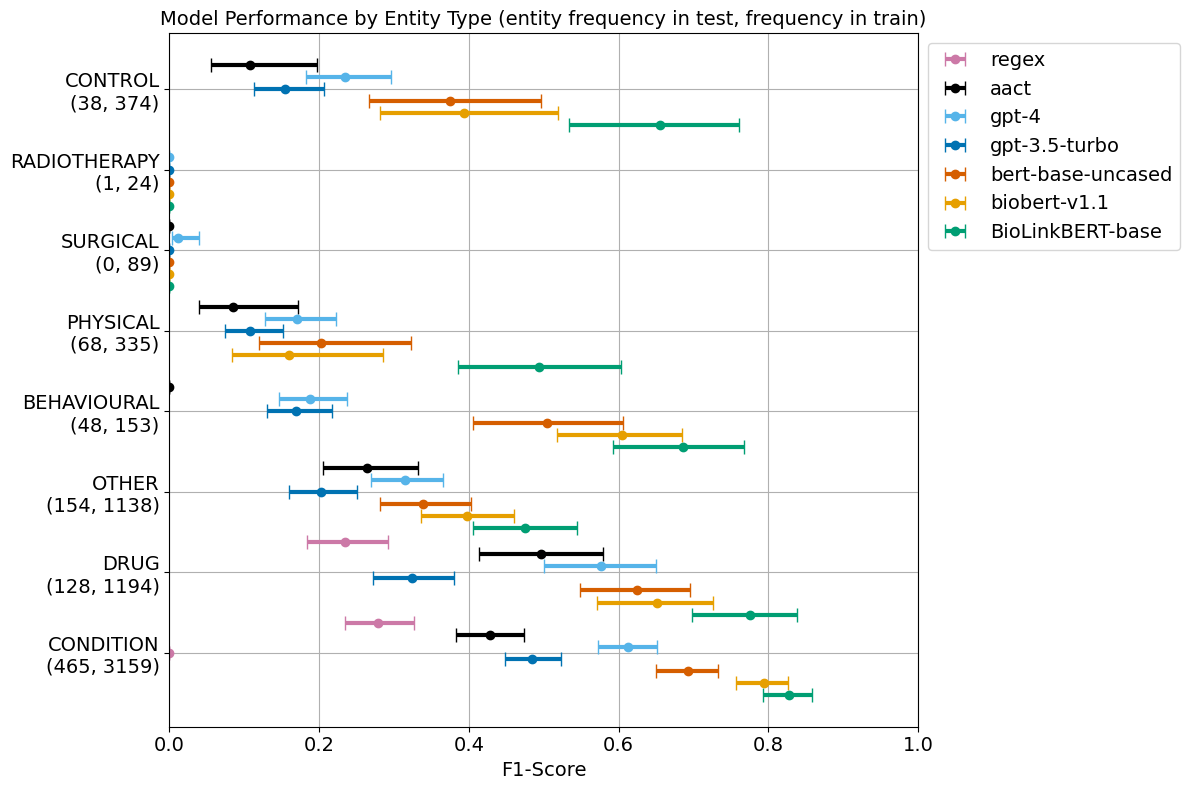

In [102]:
colors = {
    'BioLinkBERT-base': '#009E73',                    # Reddisch Purple
    'biobert-v1.1': '#E69F00',            # Orange
    'bert-base-uncased': '#D55E00',       # Vermillion
    'gpt-3.5-turbo': '#0072B2',           # Bluish Green
    'gpt-4': '#56B4E9',                   # Sky Blue
    'aact': '#000000',        # Black
    'regex': '#CC79A7'
    
}

results = results_f1_majority

# Predefined order of entity types
entity_order = ['control', 'behavioural', 'physical', 'other','drug','condition']

entity_order = ['condition', 'drug', 'other', 'physical', 'behavioural', 'radiotherapy', 'surgical', 'control']

fig, ax = plt.subplots(figsize=(12, 8))
model_spacing = 0.15  # Spacing between models within the same entity type
entity_spacing = 0.5  # Additional spacing between different entity types

# Iterate over each entity type in the predefined order
for i, entity_type in enumerate(entity_order):
    model_index = 0  # Reset model index for each entity type
    if entity_type in results:
        num_models = len(results[entity_type])
        for model_name, data in results[entity_type].items():
            center = data[0][1]
            lower, upper = data[0][0], data[0][2]
            model_name = model_name.split("_")[1]
            color = colors[model_name]
            
            # Plot
            y_position = i + (model_index - num_models / 2) * model_spacing
            ax.errorbar(center, y_position, xerr=[[center - lower], [upper - center]],elinewidth = 3, fmt='o', color=color, capsize=5, label=model_name if i == 0 else "")
            #if center == 0: 
            #    ax.text(center, y_position, f"{center:.0f}", ha='center', va='bottom')
            #else:
            #    ax.text(center, y_position, f"{center:.2f}", ha='center', va='bottom')
            model_index += 1  
            
                  
# Setting the y-ticks according to the new entity order
ax.set_yticks(np.arange(len(entity_order)))
#ax.set_yticklabels(entity_order, fontsize=14)
ax.set_yticklabels(entity_labels, fontsize=14)


ax.set_xlabel('F1-Score', fontsize=14)
ax.set_title('Model Performance by Entity Type (entity frequency in test, frequency in train)', fontsize=14)
ax.grid(True)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlim([0, 1])

# Creating a legend that doesn't repeat labels
handles, labels = plt.gca().get_legend_handles_labels()
# Add 'regex' to the legend
handles.append(ax.errorbar(0, 0, xerr=[[0], [0]], color=colors['regex'], fmt='o', elinewidth = 3, capsize=5, label='regex'))
labels.append('regex')
# Reverse handles and labels
handles = handles[::-1]
labels = labels[::-1]
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=14, bbox_to_anchor=(1, 1))

#ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig("./evaluations/plots/rebuttal_all_entities_performance.pdf")
plt.show()

,target_condition,unique_conditions_BioLinkGER-base,target_annotations,predicted_annotations
0,stroke|heart attack,stroke|heart failure,"[0, 1, 1]","[1, 1, 0]"
1,diabetes|hypertension,hypertension|diabetes,"[1, 1]","[1, 1]"
